### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 21 ноября 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [33]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [302]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = {}
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __gini(self, x, y):
        all_objects_classes = np.sum(y, axis=0)
        all_objects = float(np.sum(all_objects_classes))
        
        cum_y = np.cumsum(y, axis=0)[:-1]
        
        left_y = copy.copy(cum_y)
        right_y = all_objects_classes - cum_y
        
        left_count = np.sum(left_y, axis=1, keepdims=True)
        right_count = np.sum(right_y, axis=1, keepdims=True)
        
        l_probas = left_y / left_count
        r_probas = right_y / right_count
        
        left_impurity = np.sum(-l_probas * np.log(l_probas + 1e-6), axis=1, keepdims=True)
        right_impurity = np.sum(-r_probas * np.log(r_probas + 1e-6), axis=1, keepdims=True)
        
        impurity = left_impurity * left_count / all_objects + right_impurity * right_count / all_objects 
        
        idx = np.argmin(impurity)
        
        return idx, (x[idx] + x[idx + 1]) / 2.0, -impurity[idx]
        
    def __entropy(self, x, y):
        all_objects_classes = np.sum(y, axis=0)
        all_objects = float(np.sum(all_objects_classes))
        
        cum_y = np.cumsum(y, axis=0)[:-1]
        
        left_y = copy.copy(cum_y)
        right_y = all_objects_classes - cum_y
        
        left_count = np.sum(left_y, axis=1, keepdims=True)
        right_count = np.sum(right_y, axis=1, keepdims=True)
        
        l_probas = left_y / left_count
        r_probas = right_y / right_count
        
        left_impurity = np.sum(l_probas * (1 - l_probas), axis=1, keepdims=True)
        right_impurity = np.sum(r_probas * (1 - r_probas), axis=1, keepdims=True)
        
        impurity = left_impurity * left_count / all_objects + right_impurity * right_count / all_objects 
        
        idx = np.argmin(impurity)
        
        return idx, (x[idx] + x[idx + 1]) / 2.0, -impurity[idx]
        
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        
        max_impurity = float("-inf")
        best_feature_idx = -1
        best_thr = None
        
        for feature_idx in range(x.shape[1]):
            sorted_idxs = np.argsort(x[:, feature_idx])
            sorted_x = x[sorted_idxs, feature_idx]
            sorted_y = y[sorted_idxs]
            
            unique_y = []
            unique_thr = []
            last_thr = None
            for thr, label in zip(sorted_x, sorted_y):
                
                ohe_vector = np.zeros(self.num_class)
                ohe_vector[label] = 1
                if last_thr is not None and thr == last_thr:
                    unique_y[-1] += ohe_vector
                else:
                    unique_thr.append(thr)
                    unique_y.append(ohe_vector)
                
                last_thr = thr
            
            unique_thr = np.array(unique_thr)
            unique_y = np.vstack(unique_y)            
            n_uniques = unique_thr.shape[0]
            if n_uniques == 1:
                cur_impurity = float("-inf")
                cur_feature_idx = feature_idx
                cur_thr = unique_thr[0]
                
            else:
                if self.criterion == 'gini':
                    thr_idx, cur_thr, cur_impurity = self.__gini(unique_thr, unique_y)
                elif self.criterion == 'entropy':
                    thr_idx, cur_thr, cur_impurity = self.__entropy(unique_thr, unique_y)
                cur_feature_idx = feature_idx
                
            if cur_impurity > max_impurity:
                max_impurity = cur_impurity
                best_feature_idx = cur_feature_idx
                best_thr = cur_thr
                
        if best_thr is not None:
            if best_feature_idx not in self.feature_importances_:
                self.feature_importances_[best_feature_idx] = 0
            self.feature_importances_[best_feature_idx] += max_impurity
            
        return best_thr, best_feature_idx
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth == self.max_depth or x.shape[0] < self.min_samples_split:
            unique, counts = np.unique(y, return_counts=True)

            y_idx = np.argmax(counts)
            proba = counts / np.sum(counts)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, unique[y_idx], proba[y_idx])
            return
            
        split, f_id = self.__find_threshold(x, y)
        if split is None:
            unique, counts = np.unique(y, return_counts=True)

            y_idx = np.argmax(counts)
            proba = counts / np.sum(counts)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, unique[y_idx], proba[y_idx])
            return
        
        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, f_id, split)
        
        lx, rx, ly, ry = self.__div_samples(x, y, f_id, split)
        
        self.__fit_node(lx, ly, node_id * 2 + 1, depth + 1)
        self.__fit_node(rx, ry, node_id * 2 + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 
        
        sum_importance = sum(self.feature_importances_.values())
        for key, value in self.feature_importances_.items():
            self.feature_importances_[key] = (value / sum_importance)[0]

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [117]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [118]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [119]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.9444444444444444


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы. 
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [301]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 2):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

-inf 0 1
[-0.41878701] 1 2.5
DEPTH: 1 
		Tree: {0: (0, 1, 2.5), 1: (1, 1, 0.7142857142857143), 2: (1, 0, 1.0)} [0 0 0 1 1 1 1 1 1 1]


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [123]:
%time clf.fit(X_train, y_train)

CPU times: user 638 µs, sys: 2.05 ms, total: 2.69 ms
Wall time: 1.88 ms


DecisionTreeClassifier()

In [124]:
%time my_clf.fit(X_train, y_train)

CPU times: user 7.92 ms, sys: 2.9 ms, total: 10.8 ms
Wall time: 10.3 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [125]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    
    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    
    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    
    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))
    
        df = df.drop(feat, axis=1)
    
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc. 


In [200]:
import pandas as pd
data = pd.read_csv("/home/emperornao/Downloads/Speed Dating Data.csv", encoding='latin1')

In [201]:
data = preprocess_spd_data(data)

In [204]:
target = 'match'

In [206]:
X, y = data.loc[:, data.columns != target].values, data[target].values

In [207]:
print(X.shape, y.shape)

(8104, 32) (8104,)


In [208]:
from sklearn.metrics import roc_auc_score

In [209]:
my_clf = MyDecisionTreeClassifier(max_depth=6)
my_clf.fit(X, y)

In [210]:
roc_auc_score(my_clf.predict(X), y)

0.8110851990049751

0.81 выглядит +- для выученного train'a

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [211]:
from sklearn.model_selection import train_test_split

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) 

In [213]:
print(f"train.shape = {X_train.shape}, test.shape = {X_test.shape}")

train.shape = (6483, 32), test.shape = (1621, 32)


In [215]:
for criterion in ['gini', 'entropy']:
    my_clf = MyDecisionTreeClassifier(max_depth=6, criterion=criterion)
    my_clf.fit(X_train, y_train)
    print(f"criterion = {criterion}, score = {roc_auc_score(my_clf.predict(X_test), y_test)}")

criterion = gini, score = 0.6812952328508496
criterion = entropy, score = 0.6365885961243551


In [217]:
BEST_CRITERION='gini'

Используем gini

In [221]:
depth_history = {'train': [], 'test': [], 'depth': []}
for depth in range(3, 10):
    depth_history['depth'].append(depth)
    my_clf = MyDecisionTreeClassifier(max_depth=depth, criterion=BEST_CRITERION)
    my_clf.fit(X_train, y_train)
    
    depth_history['train'].append(roc_auc_score(my_clf.predict(X_train), y_train))
    depth_history['test'].append(roc_auc_score(my_clf.predict(X_test), y_test))

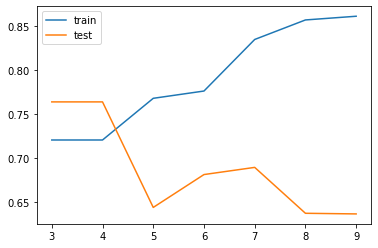

In [223]:
plt.plot(depth_history['depth'], depth_history['train'], label='train')
plt.plot(depth_history['depth'], depth_history['test'], label='test')
plt.legend()
plt.show()

In [236]:
min_samples_history = {'train': [], 'test': [], 'min_samples': []}
for min_samples_split in [1, 2, 3, 5, 10, 20, 50]:
    
    min_samples_history['min_samples'].append(min_samples_split)
    my_clf = MyDecisionTreeClassifier(min_samples_split=min_samples_split, criterion=BEST_CRITERION)
    my_clf.fit(X_train, y_train)
    
    min_samples_history['train'].append(roc_auc_score(my_clf.predict(X_train), y_train))
    min_samples_history['test'].append(roc_auc_score(my_clf.predict(X_test), y_test))

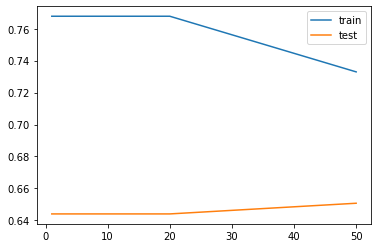

In [237]:
plt.plot(min_samples_history['min_samples'], min_samples_history['train'], label='train')
plt.plot(min_samples_history['min_samples'], min_samples_history['test'], label='test')
plt.legend()
plt.show()

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн. 
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации? 

На валидации качество падает, поэтому деревья с меньшей глубиной и бОльшим количеством 
минимальных элементов лучше обобщаются

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [274]:
my_clf = MyDecisionTreeClassifier(max_depth=4, criterion=criterion)
my_clf.fit(X_train, y_train)
print(f"criterion = {criterion}, score = {roc_auc_score(my_clf.predict(X_test), y_test)}")

criterion = entropy, score = 0.6373641780581843


In [275]:
fstr = my_clf.get_feature_importance()
columns = list(data.loc[:, data.columns != target].columns)

In [287]:
f_idxs = list(fstr.keys())
f_fstrs = [fstr[idx] for idx in f_idxs]

idxs = np.argsort(f_fstrs)[::-1]

print("Factors importance:")
for idx in idxs:
    print(f"factor idx = {f_idxs[idx]}", end=', ')
    print(f"name = {columns[f_idxs[idx]]}", end=', ')
    print(f"fstr = {f_fstrs[idx] * 100}%" )

Factors importance:
factor idx = 2, name = pid, fstr = 34.41886418600341%
factor idx = 3, name = int_corr, fstr = 13.234540781697918%
factor idx = 14, name = exphappy, fstr = 8.95311136047613%
factor idx = 8, name = imprace, fstr = 8.339605764814848%
factor idx = 19, name = amb1_1, fstr = 6.300996793946875%
factor idx = 5, name = age, fstr = 6.131386256598401%
factor idx = 26, name = shar2_1, fstr = 5.8271723414553165%
factor idx = 11, name = date, fstr = 5.815784710996867%
factor idx = 0, name = iid, fstr = 5.533797104777522%
factor idx = 17, name = intel1_1, fstr = 5.444740699232709%


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

Почему такие критерии действительно хорошо показывают разницу между распределениями. Энтропия - понятно,
но вот Джини - не понимаю до конца

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

